In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

In [2]:
# choose whether to work on a remote machine
location = "remote"
if location == "remote":
    # change this line to the where the GitHub repository is located
    os.chdir("/lustre_scratch/orlando-code/coralshift/")

In [3]:
# import relevant packages

from __future__ import annotations
import pickle
from pathlib import Path
import xarray as xa
import numpy as np
# import math as m
# import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

import wandb
from tqdm import tqdm
from sklearn import model_selection
from sklearn.preprocessing import normalize
from scipy.interpolate import interp2d
from sklearn.utils import class_weight
from scipy.ndimage import gaussian_gradient_magnitude
import xbatcher
import pandas as pd

import rasterio
# from rasterio.plot import show
import rioxarray as rio

import sklearn.metrics as sklmetrics

from coralshift.utils import file_ops, directories, utils
from coralshift.processing import spatial_data
from coralshift.plotting import spatial_plots, model_results
from coralshift.dataloading import data_structure, climate_data, bathymetry, reef_extent
from coralshift.machine_learning import baselines

2023-07-11 11:15:21.636263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/lustre_scratch/conda-envs/coralshift/share/proj failed


In [4]:
# # best models
maxent = baselines.load_model("pixelwise_all_data/maxent_0-0370d_tuned.pickle")
rf_reg = baselines.load_model("pixelwise_all_data/rf_reg_0-0370d_tuned.pickle")
brt = baselines.load_model("pixelwise_all_data/brt_0-0370d_tuned.pickle")
rf_cla = baselines.load_model("pixelwise_all_data/rf_cla_0-0370d_tuned.pickle")

# 30 iter spatials, trained on above -18
# maxent = baselines.load_model("spatial_cv_30/maxent_0-0370d_tuned.pickle")
# rf_reg = baselines.load_model("spatial_cv_30/rf_reg_0-0370d_tuned.pickle")
# brt = baselines.load_model("spatial_cv_30/brt_0-0370d_tuned.pickle")
# rf_cla = baselines.load_model("spatial_cv_30/rf_cla_0-0370d_tuned.pickle")

# 60 iter spatials, trainied on above -18
# rf_reg60= baselines.load_model("spatial_cv_60/rf_reg_0-0370d_tuned.pickle")
# brt60 = baselines.load_model("spatial_cv_60/brt_0-0370d_tuned.pickle")

# grid search models
# rf_reg = baselines.load_model("spatial_gs/rf_reg_0-0370d_tuned.pickle")
# brt = baselines.load_model("spatial_gs/brt_0-0370d_tuned.pickle")

# 0.25 models
# maxent = baselines.load_model("maxent_0-2500d_tuned.pickle")
# rf_reg = baselines.load_model("rf_reg_0-2500d_tuned.pickle")
# brt = baselines.load_model("brt_0-2500d_tuned.pickle")
# rf_cla = baselines.load_model("rf_cla_0-2500d_tuned.pickle")

{'warm_start': False, 'verbose': 2, 'tol': 0.001, 'solver': 'saga', 'penalty': 'l1', 'multi_class': 'multinomial', 'max_iter': 100, 'intercept_scaling': 2.0, 'fit_intercept': False, 'dual': False, 'C': 10.0}
{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
{'subsample': 0.6, 'n_estimators': 733, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7, 'loss': 'huber', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 80, 'bootstrap': True}


In [ ]:
brt.best_params_

In [ ]:
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
)



grid_search = initialise_grid_search("brt", brt.best_params_, cv=2)

all_data = baselines.get_comparison_xa_ds(d_resolution=1/27)
all_data = spatial_data.combine_ds_tiles(all_data, 1/27)
train_test_lat_divide = -18
train_direction = "S"
# res_string = utils.replace_dot_with_dash(f"{1/27:.04f}d")

# define train/test split so it's the same for all models
(X_trains, X_tests, y_trains, y_tests, _, _) = baselines.spatial_split_train_test(
    xa_dss = all_data,
    gt_label = "gt",
    split_type="spatial",
    # test_fraction=test_fraction,
    train_test_lat_divide=train_test_lat_divide,
    train_direction = train_direction
)



In [ ]:
get_multiindex_min_max(all_data.to_dataframe())

In [ ]:
grid_search

In [ ]:
3**4

In [ ]:
len(list(grid))

In [ ]:
len(remove_duplicates(grid))

In [ ]:

rf_reg_no = RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=10, min_samples_leaf=10, max_features=6)

X_train, X_test, y_train, y_test, _, _ = baselines.spatial_split_train_test(
    xa_dss = all_data, 
    split_type="spatial",
    train_test_lat_divide = -18,
    train_direction = "S",
    bath_mask=True
)



In [ ]:
def visualise_region_class_imbalance(region_imbalance_dict: dict):
    df = pd.DataFrame.from_dict(
        region_imbalance_dict,
        orient="index",
        columns=["Total Grid Cells", "Fractional Coral Presence"],
    )
    df = df.reset_index().rename(columns={"index": "Region"})

    xs, y1s, y2s = df.columns[0], df.columns[1], df.columns[2]

    colors = ["#78B7C5", "#E1AF00"]
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        x=xs, y=y1s, data=df, color=colors[0], label="total grid cells containing coral"
    )
    ax2 = ax.twinx()
    sns.barplot(
        x=xs,
        y=y2s,
        data=df,
        color=colors[1],
        label="fraction of grid cells containing coral",
    )

    # format bar widths
    width_scale = 0.45
    for bar in ax.containers[0]:
        bar.set_width(bar.get_width() * width_scale)
    for bar in ax2.containers[0]:
        x = bar.get_x()
        w = bar.get_width()
        bar.set_x(x + w * (1 - width_scale))
        bar.set_width(w * width_scale)

    # format legend
    (h1, l1), (h2, l2) = ax.get_legend_handles_labels(), ax2.get_legend_handles_labels()
    ax.legend(h1, l1, loc="upper left")
    ax2.legend(h2, l2, loc="upper right")

    # formatting
    ax.set_xlabel("GBR Region")
    ax.set_ylabel("Total Grid Cells")
    ax2.set_ylabel("Coral Presence")
    ax2.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_ylim((0, 4500))
    ax2.set_ylim((0, 0.2))

In [5]:


all_ds_to_combine = baselines.get_comparison_xa_ds(d_resolution=1/27)
all_data = spatial_data.combine_ds_tiles(all_ds_to_combine, resolution_d=1/27)

models_output_dict = baselines.n_random_runs_preds_across_models(
    # model_types=["maxent", "rf_reg", "brt", "rf_cla"],
    # models=[maxent, rf_reg, brt, rf_cla], 
    # model_types = ["rf_reg", "brt"],
    # models = [rf_reg, brt],
    model_types=["rf_cla", "maxent"],
    models = [rf_cla, maxent],
    xa_dss = all_data, 
    runs_n=10,
    split_type="spatial",
    train_test_lat_divide=-18,
    train_direction="N")

# rocs_n_runs(models_output_dict["brt"], binarize_threshold=0.2)

Pre-processing xarray objects: 4it [00:01,  3.45it/s]                       
Inference on 10 train-test splits:   0%|          | 0/10 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
Inference on 10 train-test splits:  10%|█         | 1/10 [00:01<00:14,  1.63s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
Inference on 10 train-test splits:  20%|██        | 2/10 [00:02<00:09,  1.18s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
Inference on 10 train-test splits:  30%|███       | 3/10 [00:03<00:07,  1.13s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
Inf

Iterating over models: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s]


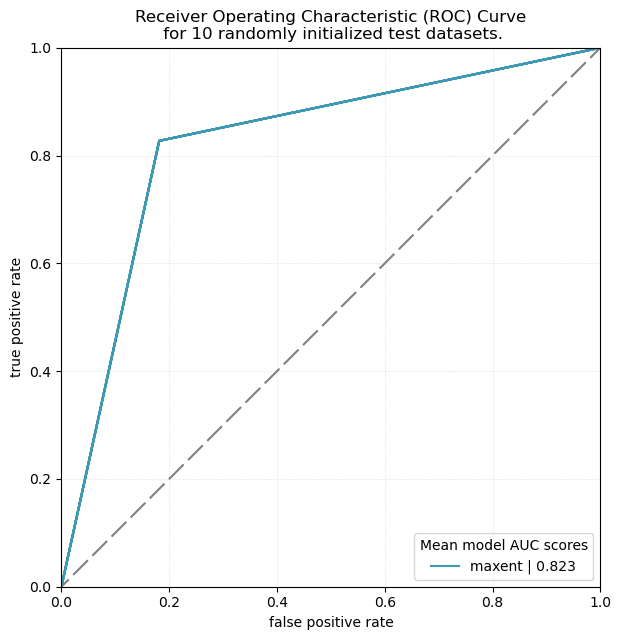

In [8]:
me_dict = {"maxent": models_output_dict["maxent"]}
baselines.models_rocs_n_runs(me_dict, binarize_threshold=0.25)

Iterating over models: 100%|██████████| 1/1 [00:00<00:00, 37.58it/s]


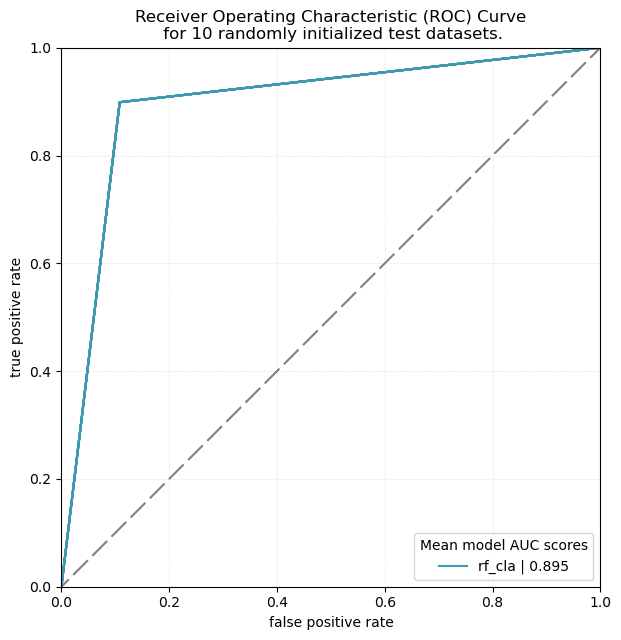

In [9]:
rf_cla_dict = {"rf_cla": models_output_dict["rf_cla"]}
baselines.models_rocs_n_runs(rf_cla_dict, binarize_threshold=0.25)

Iterating over models: 100%|██████████| 2/2 [00:00<00:00, 40.86it/s]


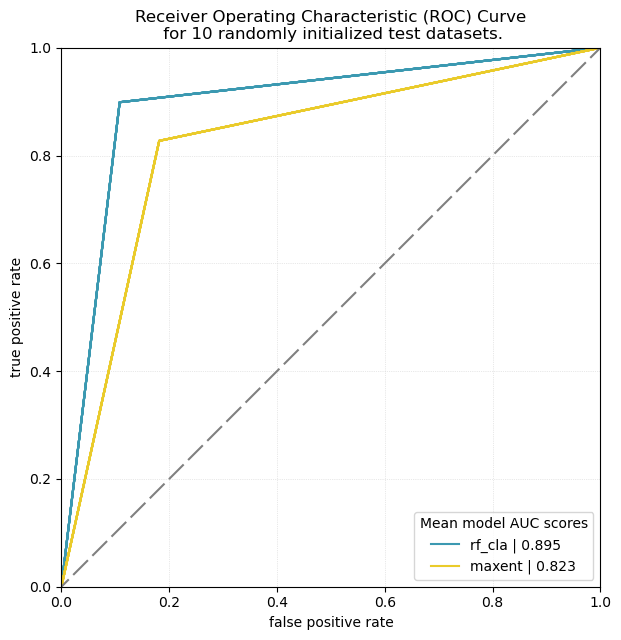

In [6]:
baselines.models_rocs_n_runs(models_output_dict, binarize_threshold=0.25)

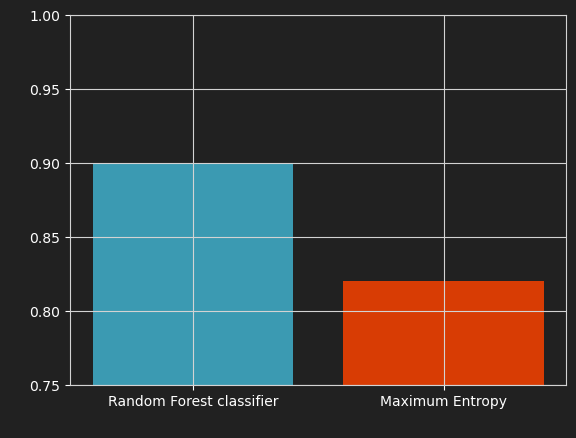

In [19]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "#212121",
    "axes.facecolor": "#212121",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "#212121",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgrey",
    "figure.facecolor": "#212121",
    "figure.edgecolor": "#212121",
    "savefig.facecolor": "#212121",
    "savefig.edgecolor": "#212121"})

values = {
        "Random Forest classifier": 0.90,
    "Maximum Entropy": 0.82,
}

# Extract labels and heights from the dictionary
labels = list(values.keys())
heights = list(values.values())

colors = ["#3B9AB2", "#d83c04"]
# Create a figure and axis
fig, ax = plt.subplots()

# Create the bar chart
ax.bar(labels, heights, color=colors)

# Set the title and labels
# ax.set_title("Bar Chart")
ax.set_xlabel("Models")
ax.set_ylabel("Values")
ax.set_ylim([0.75,1])
ax.grid()

# Display the chart
plt.show()


In [ ]:
models_rocs_n_runs(models_output_dict, binarize_threshold=0.25)

In [ ]:
model_type="brt"
ds = outputs_to_xa_ds(models_output_dict[model_type][0][0],(models_output_dict[model_type][0][1]))
plot_spatial_diffs(ds["predictions"], ds["labels"], figsize=(16,14), cbar_pad =0.11)

In [ ]:
# def plot_confusion_matrix(labels, predictions, label_threshold: float = 0, fax=None) -> None:
#     cmap = spatial_plots.get_cbar("lim")

#     if not check_discrete(predictions):
#         labels = baselines.threshold_array(labels, threshold=label_threshold)
#         predictions = baselines.threshold_array(predictions, threshold=label_threshold)

#     classes = ["coral absent", "coral present"]
#     # initialise confusion matrix
#     cm = sklmetrics.confusion_matrix(labels, predictions)
#     disp = sklmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
#         display_labels=classes
#         )
#     if fax:
#         disp.plot(cmap=cmap, text_kw={"color": "black"}, ax=fax[1])
#     else:
#         disp.plot(cmap=cmap, text_kw={"color": "black"})

model_type="rf_reg"
plot_confusion_matrix(models_output_dict[model_type][0][0],models_output_dict[model_type][0][1], label_threshold=0.25)

In [ ]:
model_type="rf_reg"
baselines.investigate_label_thresholds(np.linspace(0,0.9999,10), models_output_dict[model_type][0][0],models_output_dict[model_type][0][1])

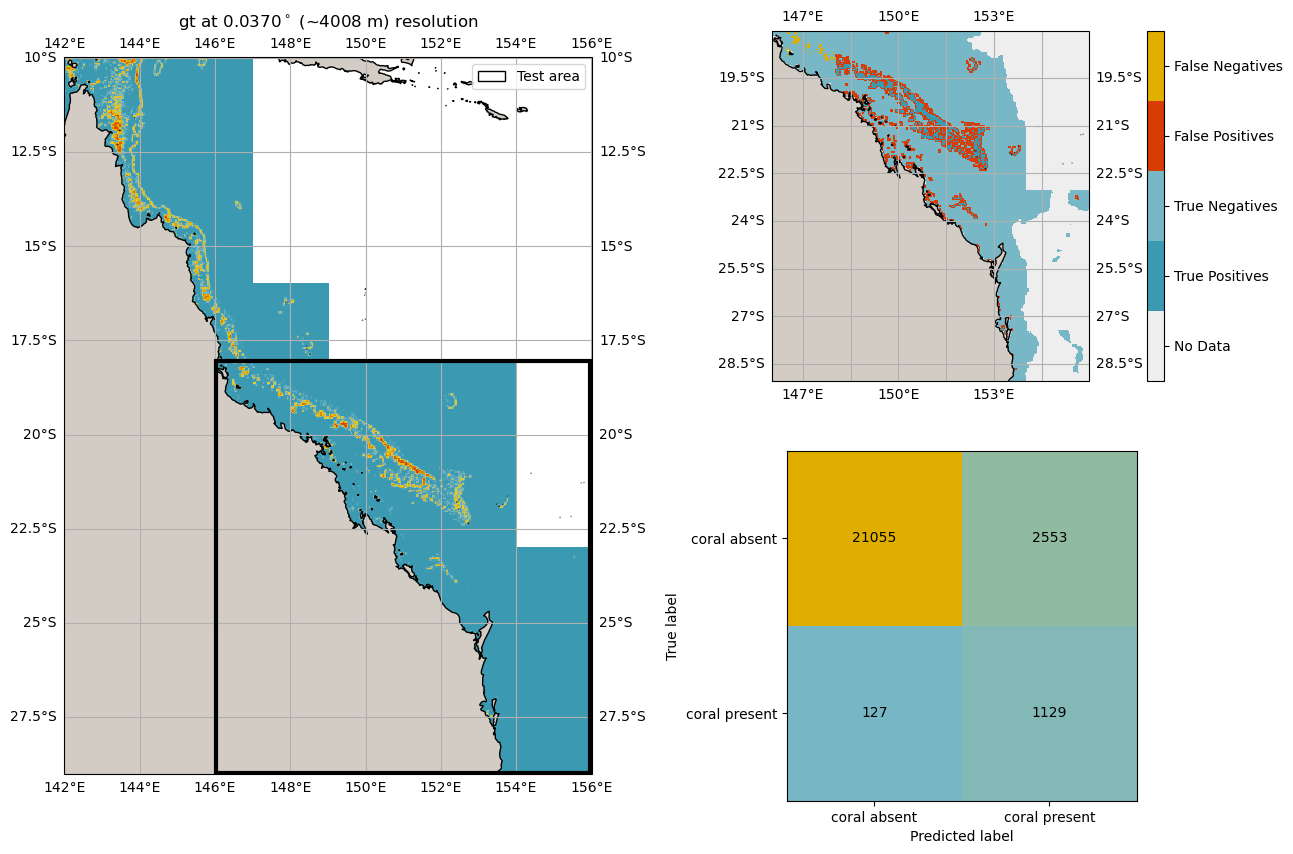

In [11]:
def plot_model_result(all_data, labels, predictions, model_type: str =" ", figsize = [15,10]):

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2)

    # left plot (total map)
    ax_context = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
    spatial_plots.plot_spatial(fax=(fig, ax_context), xa_da=all_data["gt"], cbar=False)

    # determine the test coords
    limits_dict = utils.get_multiindex_min_max(labels)
    lat_min, lat_max = limits_dict["latitude"]["min"], limits_dict["latitude"]["max"]
    lon_min, lon_max = limits_dict["longitude"]["min"], limits_dict["longitude"]["max"]
    rectangle = patches.Rectangle(
        (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth=3, edgecolor='k', facecolor='none', zorder=10)
    ax_context.add_patch(rectangle)
    
    legend_patches = [patches.Patch(facecolor='none', edgecolor='k', label='Test area')]
    ax_context.legend(handles=legend_patches)

     
    # right plots (spatial cm, cm)
    ax_spatial_cm = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    model_results.model_output_to_spatial_confusion(labels, predictions, fax=(fig, ax_spatial_cm), cbar_pad=0.11)
    ax_cm = fig.add_subplot(gs[1, 1])
    model_results.plot_confusion_matrix(labels, predictions, fax=(fig, ax_cm))


model_type = "rf_cla"
plot_model_result(
    all_data, models_output_dict[model_type][0][0], models_output_dict[model_type][0][1], model_type=model_type)


In [ ]:
len(models_output_dict[model_type][0][0])

In [ ]:
np.where(models_output_dict[model_type][0][0].to_numpy() > 0)

In [ ]:
(models_output_dict[model_type][0][0] > 0).sum()/len(models_output_dict[model_type][0][0])

In [ ]:
sum(sum(np.where(models_output_dict[model_type][0][0] > 0)))

In [ ]:
# def model_output_to_spatial_confusion(label, prediction, lat_lims: tuple[float]=None, lon_lims: tuple[float]=None, fax=None, cbar_pad=0.1) -> None:    
#     ds = outputs_to_xa_ds(label, prediction)
#     confusion_values, vals_dict = model_results.spatial_confusion_matrix_da(
#         ds["predictions"], ds["labels"]
#     )
#     if lat_lims and lon_lims:
#         region = {"latitude": slice(min(lat_lims), max(lat_lims)), "longitude": slice(min(lon_lims), max(lon_lims))}
#         ds = confusion_values.sel(region)
#     ds["comparison"] = confusion_values

#     plot_spatial_confusion(ds, "labels", "predictions", vals_dict=vals_dict, fax=fax, cbar_pad=cbar_pad)


# def plot_pixelwise_model_result(all_data, labels, predictions, model_type: str =" ", figsize = [20,20], thresh_val = -0.25,
#     lat_lims=None, lon_lims=None):
#     fig = plt.figure(figsize=figsize)
#     gs = gridspec.GridSpec(2, 2)

#     # left plot (total map)
#     # ax_context = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
#     # spatial_plots.plot_spatial(fax=(fig, ax_context), xa_da=all_data["gt"], cbar=False)
#     if model_type == "brt" or model_type == "rf_reg":
#         predictions = baselines.threshold_array(predictions, thresh_val)

#     # right plots (spatial cm, cm)
#     ax_spatial_cm = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
#     model_output_to_spatial_confusion(
#         labels, predictions, lat_lims=lat_lims, lon_lims=lon_lims, fax=(fig, ax_spatial_cm), cbar_pad=0.11)
#     # ax_cm = fig.add_subplot(gs[1,0])
#     # plot_confusion_matrix(labels, predictions, fax=(fig, ax_cm), colorbar=False)




    # fig, ax = plt.subplots(1,2,figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()})
    # plot_confusion_matrix(labels, predictions, fax=(fig, ax[1]))
    # model_output_to_spatial_confusion(labels, predictions, fax=(fig, ax[0]), cbar_pad=0.11)


model_type = "brt"

plot_pixelwise_model_result(
    all_data, models_output_dict[model_type][0][0], models_output_dict[model_type][0][1], model_type=model_type, thresh_val = 0.25,
    # lat_lims=(-17,-10), lon_lims=(142,147)
    # lat_lims=(-17,-10), lon_lims=(146,148)
    # lat_lims=(-25,-20), lon_lims=(145,154)

    )

In [ ]:
plot_confusion_matrix(models_output_dict[model_type][0][0],models_output_dict[model_type][0][1], label_threshold=0.25)

In [ ]:
model_type = "rf_cla"
sklmetrics.balanced_accuracy_score(models_output_dict[model_type][0][0], models_output_dict[model_type][0][1])

In [ ]:
spatial_plots.plot_spatial(all_data["gt"])

In [ ]:
# new_brt = GradientBoostingRegressor(random_state=42)
# new_brt.fit(timeav_X[:100000], timeav_y[:100000])

# preds = new_brt.predict(X_test.drop(columns=["latitude", "longitude"]).groupby(['latitude', 'longitude']).mean())
# y_test = y_test.groupby(['latitude', 'longitude']).mean()
# rocs_n_runs([(y_test, preds)])

In [ ]:
rf_cla_outcomes = models_output_dict["rf_cla"]
rf_cla_outcomes[0][0]

In [ ]:
# def check_discrete(array):
#     # Check if all elements are whole numbers (integers)
#     if np.all(np.equal(np.mod(array, 1), 0)):
#         return True
#     # Check if any elements are decimals (floating-point numbers)
#     elif np.any(np.not_equal(np.mod(array, 1), 0)):
#         return False
#     else:
#         return False


# def plot_confusion_matrix(labels, predictions, label_threshold: float = 0, fax=None, colorbar: bool=False) -> None:
#     cmap = spatial_plots.get_cbar("lim")

#     if not check_discrete(predictions):
#         labels = baselines.threshold_array(predictions, threshold=label_threshold)
#         predictions = baselines.threshold_array(predictions, threshold=label_threshold)

#     classes = ["coral absent", "coral present"]
#     # initialise confusion matrix
#     cm = sklmetrics.confusion_matrix(labels, predictions)
#     disp = sklmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
#         display_labels=classes
#         )
#     if fax:
#         disp.plot(cmap=cmap, colorbar = colorbar, text_kw={"color": "black"}, ax=fax[1])
#     else:
#         disp.plot(cmap=cmap, colorbar = colorbar, text_kw={"color": "black"})


plot_confusion_matrix(models_output_dict["rf_cla"][0][0],models_output_dict["rf_cla"][0][1])
                        

In [ ]:
(baselines.threshold_array(models_output_dict["brt"][0][1], threshold=0))

In [ ]:
check_discrete(models_output_dict["rf_reg"][0][0])

In [ ]:
# import seaborn as sns
# import matplotlib.colors as mcolors
# import cartopy.feature as cfeature
# import cartopy.crs as ccrs

# def plot_spatial_confusion(
#     xa_ds: xa.Dataset, ground_truth_var: str, predicted_var: str, vals_dict: dict, fax = None, cbar_pad = 0.1
# ) -> xa.Dataset:
#     """Plot a spatial confusion matrix based on the predicted and ground truth variables in the xarray dataset.

#     Parameters
#     ----------
#         xa_ds (xarray.Dataset): Input xarray dataset.
#         ground_truth_var (str): Name of the ground truth variable in the dataset.
#         predicted_var (str): Name of the predicted variable in the dataset.

#     Returns
#     -------    -------
#         xarray.Dataset: Updated xarray dataset with the "comparison" variable added.
#     """
#     # calculate spatial confusion values and assign to new variable in Dataset
#     map_proj = ccrs.PlateCarree()
#     if not fax:
#         # may need to change this
#         fig = plt.figure(figsize=[16,8])
#         ax = plt.axes(projection=map_proj)
#     else:
#         fig = fax[0]
#         ax = fax[1]
        
#     # from Wes Anderson: https://github.com/karthik/wesanderson/blob/master/R/colors.R
#     cmap_colors = ["#EEEEEE", "#3B9AB2", "#78B7C5", "#d83c04", "#E1AF00"]

#     im = xa_ds["comparison"].plot.imshow(ax=ax, vmin=0, vmax=4, cmap = mcolors.ListedColormap(cmap_colors))

#     spatial_plots.format_spatial_plot(im, fig, ax, title="", name="", cbar=False, edgecolor="black")
#     ax.set_aspect("equal")
#     # remove old colorbar
#     cb = im.colorbar
#     cb.remove()

#     colorbar = plt.colorbar(im, ax = [ax], location = 'right', pad=cbar_pad)
#     num_ticks = len(cmap_colors)
#     vmin, vmax = colorbar.vmin, colorbar.vmax
#     colorbar.set_ticks([vmin + (vmax - vmin) / num_ticks * (0.5 + i) for i in range(num_ticks)])
#     colorbar.set_ticklabels(list(vals_dict.keys()), rotation=0)


# # plot_spatial_confusion(ds, "gt", "prediction")

In [ ]:


model_output_to_spatial_confusion(models_output_dict["maxent"][0][0], models_output_dict["maxent"][0][1])

In [ ]:
sum(sum(mask.values))

In [ ]:
mask.compute()

In [ ]:

# def plot_shallow_mask(xa_d: xa.Dataset | xa.DataArray, limits: tuple[float] = [-2000,0], title: str = " ") -> None:
#     # plot shallow water mask
#     shallow_mask = spatial_data.generate_var_mask(xa_d)
#     spatial_plots.plot_spatial(shallow_mask, cmap_type="lim", title=title, cbar=False)
#     return shallow_mask

mask = spatial_plots.plot_variable_mask(all_data)


# Here I take my stand

In [ ]:
all_ds = baselines.get_comparison_xa_ds(d_resolution=1/27)
combined = spatial_data.combine_ds_tiles(all_ds, resolution_d=1/27)

spatial_plots.plot_spatial(combined["gt"].sel({"latitude": slice(-20,-17), "longitude": slice(146,148)}))

In [ ]:
all_ds[1]["gt"].plot(vmax=0.2)

In [ ]:
spatial_plots.plot_spatial(combined["gt"])

In [ ]:
# get list of region das

# 

# class weighting necessary, as shown by this plot
region_dict = dict(zip([da.region for da in das], das))
region_imbalance = calculate_region_class_imbalance(region_dict)
model_results.visualise_region_class_imbalance(region_imbalance_dict)
model_results.visualise_region_class_imbalance(region_imbalance)

In [ ]:
X_trains, X_tests, y_trains, y_tests, train_coords_list, test_coords_list = spatial_split_train_test(dss, data_type="discrete", bath_mask=False)
sum(y_tests[0])/len(y_tests[0])

In [ ]:
dss[0]["current_m_max"]

In [ ]:
xa_dss_to_df(dss)[0][0]

In [ ]:
confusion_values, vals_dict = model_results.spatial_confusion_matrix_da(
    ds["prediction"], ds["gt"]
)
ds["comparison"] = confusion_values

ds["comparison"].isel(time=0).plot.imshow(vmin=0, vmax=4)


In [ ]:
sum(ds.isel(time=0)["prediction"]==1)

In [ ]:
df = pd.DataFrame({"gt": models_output_dict["rf_cla"][0][0], "prediction": models_output_dict["rf_cla"][0][1]})
df.head()
selected_rows = df.loc[(-16 <= df.index.get_level_values('latitude')) & (df.index.get_level_values('latitude') <= -10) &
                       (142 <= df.index.get_level_values('longitude')) & (df.index.get_level_values('longitude') <= 144)]

ds = selected_rows.to_xarray().sortby(["longitude", "latitude"])

In [ ]:
f, ax = plt.subplots(1,2, figsize=(10,7))

ds.isel(time=0)["gt"].plot(ax=ax[0])
ds.isel(time=0)["prediction"].plot(ax=ax[1])

ax[0].set_aspect("equal")
ax[1].set_aspect("equal")

In [ ]:
plot_spatial_confusion(ds.isel(time=0), "gt", "prediction")

In [ ]:
df = pd.DataFrame({"gt": models_output_dict["rf_cla"][0][0], "prediction": models_output_dict["rf_cla"][0][1]})
confusion_values, vals_dict = model_results.spatial_confusion_matrix_da(
    ds["prediction"], ds["gt"]
)
ds = df.to_xarray().sortby(["longitude", "latitude"])
ds["comparison"] = confusion_values

spplot_spatial_confusion(ds, "gt", "prediction")

In [ ]:
series = models_output_dict["rf_reg"][0][0]

# problems with casting, obviously. Need to run on one area at a time
series.to_xarray().isel(time=0).plot()

In [ ]:
f, ax = plt.subplots(1,2, figsize=(10,7))

ds.isel(time=0)["gt"].plot(ax=ax[0])
ds.isel(time=0)["prediction"].plot(ax=ax[1])

ax[0].set_aspect("equal")
ax[1].set_aspect("equal")

In [ ]:
series.to_dataframe()

In [ ]:
import pandas as pd

# Define latitude and longitude ranges
latitude_range = (-15, -10)
longitude_range = (142, 143)

# Perform boolean indexing to select the desired latitudes and longitudes
selected_series = series[
    (series.index.get_level_values("latitude") >= latitude_range[0])
    & (series.index.get_level_values("latitude") <= latitude_range[1])
    & (series.index.get_level_values("longitude") >= longitude_range[0])
    & (series.index.get_level_values("longitude") <= longitude_range[1])
]

In [ ]:
index = pd.MultiIndex.from_product(
    [["lat1", "lat2"], ["lon1", "lon2"], ["time1", "time2"]],
    names=["latitude", "longitude", "time"],
)
data = [1, 2, 3, 4, 5, 6, 7, 8]
series = pd.Series(data, index=index)

series.unstack()

In [ ]:
f,ax=plt.subplots()
selected_series.to_xarray().sortby("longitude").isel(time=0).plot(ax=ax)

ax.set_aspect("equal")

In [ ]:
models_output_dict["maxent"]

In [ ]:
len(models_output_dict)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

 

ModelInitialiser().get_search_grid("rf_cla")

In [ ]:
all_data = baselines.get_comparison_xa_ds(d_resolution=0.0368)
maxent = load_model("maxent_0-0368d_tuned.pickle")
(X_train, X_test, y_train, y_test, _, _) = baselines.spatial_split_train_test(
    utils.list_if_not_already(all_data),
    "gt",
    split_type="pixel",
    test_fraction=0.25,
)

In [ ]:
run_outcomes = n_random_runs_preds(maxent, all_data, 20)

In [ ]:
from sklearn import metrics as sklmetrics


rocs_n_runs(run_outcomes)

In [ ]:
test = xa.open_dataset(directories.get_comparison_dir() / "Great_Barrier_Reef_D/0-0368d_arrays/all_0-0368d_comparative.nc")
test

In [ ]:
# choose resolution (should be above 1000m for processing in decent time)
target_resolution_m, target_resolution_d = spatial_data.choose_resolution(
    resolution=4000, unit="m")

# Combining data and processing to be ML model-ready

In [ ]:
chunk_dict = {"latitude": 10, "longitude": 10, "time": 50}
monthly_means = xa.open_dataset(directories.get_datasets_dir() / "test/cmems_gopr_monthly_A_old.nc", chunks=chunk_dict)
monthly_means

In [ ]:
directories.get_datasets_dir()

In [ ]:
def split_nc_files(dir_path, new_dir: str = None, incl_subdirs: bool=False):
    nc_paths = file_ops.return_list_filepaths(dir_path, ".nc", incl_subdirs=incl_subdirs)
    save_dir = nc_paths[0].parent

    if new_dir:
        save_dir = file_ops.guarantee_existence(save_dir / new_dir)

    for path in nc_paths:
        split_nc_file(path, save_dir)


def split_nc_file(path, save_dir):
    # Load the NetCDF file as an xarray dataset
    path = Path(path)

    dataset = xa.open_dataset(path, decode_coords="all")

    # Check if the loaded object is an xarray dataset
    # if isinstance(dataset, xa.DataArray):
    if len(list(dataset.data_vars)) == 1:
        # print(f"{path} is already a xa.DataArray. No further action taken")
        # save copy to new folder
        new_file_path = (save_dir / list(dataset.data_vars)[0]).with_suffix(".nc")
        # TODO: replace with save_nc
        if not new_file_path.is_file():
            dataset.rio.write_crs("EPSG:4326", inplace=True)
            dataset.to_netcdf(new_file_path)
        else:
            print(f"{new_file_path} already exists.")
        return None

    # Get the folder path and file name
    folder_path, file_name = path.parent, path.stem

    # Iterate over each variable in the dataset
    for variable in tqdm(dataset.data_vars, desc = f" Unpacking data_vars in {path}"):
        # ignore spatial_data
        if variable == "spatial_data":
            continue  # Skip to the next iteration if the variable is "spatial_data"

        # Get the data array for the variable
        data_array = dataset[variable]

        # Create a new file name based on the variable name
        new_file_name = f"{variable}.nc"

        # Create the new file path
        new_file_path = (save_dir / new_file_name).with_suffix(".nc")
        if not new_file_path.is_file():
            data_array.rio.write_crs("EPSG:4326", inplace=True)
            # Write the new dataset to a NetCDF file
            data_array.to_netcdf(new_file_path)
        else:
            print(f"{new_file_path} already exists.")


def ncfile_to_resolution_tensor(ncfile_path, target_resolution_d: float = target_resolution_d, name: str=None) -> tf.Tensor:

    da = xa.open_dataarray(ncfile_path, engine="netcdf4", decode_coords="all")  # may not need type
    # resolve
    upsampled_ds = upsample_xarray_to_target(spatial_data.process_xa_d(da), target_resolution_d)

    data = upsampled_ds.data
    # get data as tensor
    return tf.convert_to_tensor(data, name=Path(ncfile_path).stem)   # not sure about name here


def ncfiles_to_tf_dataset(ncfile_paths, target_resolution_d: float, name: str = None) -> tf.data.Dataset:
    # gen = lambda: (ncfile_to_resolution_tensor(x, target_resolution_d, name) for x in ncfiles)
    gen = lambda: (ncfile_to_resolution_tensor(x) for x in ncfile_paths)

    return tf.data.Dataset.from_generator(gen, output_types=tf.float32, name="asdf")


def remove_empty_variables(dataset):
    # Create a mask indicating variables with all zeros, all NaNs, or a mix of zeros and NaNs
    mask = ((dataset == 0) | np.isnan(dataset)).all(dim=['latitude', 'longitude', 'time'])
    
    # Filter out variables based on the mask
    variables = np.array(dataset.data_vars)[~mask.to_array().values]
    dropped_variables = list(set(dataset.data_vars) - set(variables))
    print(f"{dropped_variables} were removed from the dataset")

    filtered_dataset = dataset.drop_vars(names=dropped_variables)

    return filtered_dataset, dropped_variables


def convert_dataset_to_array(dataset):
    # Convert the dataset to a NumPy array
    array = dataset.to_array().values
    
    # Transpose the dimensions to match the desired shape (latitudes x longitudes x variable_num x time)
    array = np.transpose(array, (1, 2, 0, 3))
    
    return array


def process_xa_ds_ml_ready(
    xa_ds: xa.Dataset,
    feature_vars: list[str] = ["vo", "so", "thetao"],
    gt_var: str = None,
    normalise: bool = True,
    onehot: bool = True,
    conv: bool = False):

    # remove any variables which are entirely none/all zero (looking at you sea ice)
    xa_ds, dropped = remove_empty_variables(xa_ds)

    # features array (discarding nans)
    X_array = xa_ds[[feature for feature in feature_vars if feature not in dropped]]
    # gt array
    y_array = xa_ds.isel(time=-1)[gt_var]

    Xs = convert_dataset_to_array(X_array)
    ys = y_array.values

    if normalise:
        Xs = spatial_data.normalise_3d_array(Xs)

    if onehot:
        Xs = spatial_data.encode_nans_one_hot(Xs)
    Xs = spatial_data.naive_nan_replacement(Xs)

    if not conv:
        # if not conv (standard lstm), cast to column
        Xs = spatial_data.spatial_array_to_column(Xs)
        ys = spatial_data.spatial_array_to_column(ys)

    return Xs, ys


def spatial_array_to_column(array: np.ndarray) -> np.ndarray:
    """Reshape the first two dimensions of a 3D NumPy array to a column vector.

    Parameters
    ----------
    array (np.ndarray): The input 3D NumPy array.

    Returns
    -------
    np.ndarray: The reshaped column vector.

    Examples
    --------
    array = np.random.rand(lat, lon, var, ...)
    column_vector = spatial_array_to_column(array)
    print(column_vector.shape)
    (lat x lon, var, ...)
    """
    array_shape = array.shape
    new_shape = (array_shape[0] * array_shape[1], *array.shape[2:])
    return np.reshape(array, new_shape)


def upsample_xarray_to_target(
    xa_array: xa.DataArray | xa.Dataset,
    target_resolution: float,
    method=rasterio.enums.Resampling.bilinear,
    name: str = None,
) -> xa.Dataset:
    """
    Upsamples an xarray DataArray or Dataset to a target resolution.

    Parameters
    ----------
        xa_array (xarray.DataArray or xarray.Dataset): The input xarray object to upsample.
        target_resolution (float): The target resolution in degrees.

    Returns
    -------
        xarray.Dataset: The upsampled dataset.

    Notes
    -----
        - The function resamples the input xarray object by coarsening it to a target resolution.
        - The current implementation supports upsampling along latitude and longitude dimensions only.
        - The function calculates the degree resolution of the input dataset and scales it to match the target
        resolution.
        - The resampling is performed by coarsening the dataset using a mean operation.
    """
    # N.B. not perfect at getting starts/ends matching up It works fine when not trying to match the coords of another
    # TODO: enable flexible upsampling by time also
    lat_lims = spatial_data.xarray_coord_limits(xa_array, "latitude")
    lon_lims = spatial_data.xarray_coord_limits(xa_array, "longitude")

    dummy_xa = spatial_data.generate_dummy_xa(target_resolution, lat_lims, lon_lims)

    return upsample_xa_d_to_other(xa_array, dummy_xa, method=method, name=name)

    
def upsample_xa_d_to_other(
    xa_d: xa.DataArray | xa.Dataset,
    target_xa_d: xa.DataArray | xa.Dataset,
    method=rasterio.enums.Resampling.bilinear,
    name: str = None,
    var_name: str = None,
) -> xa.DataArray | xa.Dataset:
    """
    Upsample a given xarray DataArray or Dataset to match the spatial characteristics of another DataArray or Dataset.

    Parameters
    ----------
    xa_d (xarray.DataArray or xarray.Dataset): The xarray object to upsample.
    target_xa_d (xarray.DataArray or xarray.Dataset): The target xarray object with the desired spatial characteristics
        (e.g., resolution, extent).
    method (rasterio.enums.Resampling, optional): The resampling method to use during upsampling. Default is
        rasterio.enums.Resampling.bilinear.
    name (str, optional): The name to assign to the upsampled DataArray or Dataset. If not provided, the original
        name is used.

    Returns
    -------
    xarray.DataArray or xarray.Dataset: The upsampled xarray object with matching spatial characteristics as the target.
    """
    xa_da = file_ops.extract_variable(xa_d, var_name)
    xa_resampled = xa_da.rio.reproject_match(target_xa_d, resampling=method)
    xa_processed = spatial_data.process_xa_d(xa_resampled)
    if name:
        return xa_processed.rename(name)
    else:
        return xa_processed

In [ ]:
daily_climate = spatial_data.process_xa_d(xa.open_dataset(
    directories.get_daily_cmems_dir() / "cmems_gopr_daily.nc", chunks=chunk_dict, decode_coords="all"))

bath = spatial_data.process_xa_d(xa.open_dataarray(
    directories.get_bathymetry_datasets_dir() / "bathymetry_A_0-03691_upsampled.nc", chunks=chunk_dict, decode_coords="all"))

slopes = spatial_data.process_xa_d(xa.open_dataarray(
    directories.get_gradients_dir() / "bathymetry_B_0.03668_gradients.nc", chunks=chunk_dict, decode_coords="all"))

gt = spatial_data.process_xa_d(xa.open_dataarray(
    directories.get_gt_files_dir() / "coral_region_A_1000m_mean.nc", chunks=chunk_dict, decode_coords="all"))


In [ ]:
from coralshift.utils import utils 
def resample_list_xa_ds_to_target_res_and_save(
    xa_das: list[xa.DataArray],
    target_resolution_d: float,
    save_dir: Path = None,
    lat_lims: tuple[float] = (-10, -17),
    lon_lims: tuple[float] = (142, 147),
) -> None:
    """
    Resamples a list of xarray DataArrays to a target resolution, and saves the resampled DataArrays to NetCDF files.

    Parameters
    ----------
        xa_das (list[xa.DataArray]): A list of xarray DataArrays to be resampled.
        target_resolution_d (float): The target resolution in degrees or meters, depending on the unit specified.
        unit (str, optional): The unit of the target resolution. Defaults to "m".
        lat_lims (tuple[float], optional): Latitude limits for the dummy DataArray used for resampling.
            Defaults to (-10, -17).
        lon_lims (tuple[float], optional): Longitude limits for the dummy DataArray used for resampling.
            Defaults to (142, 147).

    Returns
    -------
        None
    """

    dummy_xa = spatial_data.generate_dummy_xa(target_resolution_d, lat_lims, lon_lims)

    if not save_dir:
        save_dir = file_ops.generate_filepath(
            (
                directories.get_comparison_dir()
                / utils.replace_dot_with_dash(f"{target_resolution_d:.05f}d_arrays")
            )
        )

    for xa_da in tqdm(
        xa_das,
        desc=f"Resampling xarray DataArrays to {target_resolution_d:.05f}d",
        position=1,
        leave=True,
    ):
        if isinstance(xa_da, xa.Dataset):
            name = "ds"
        else:
            name = xa_da.name
        filename = utils.replace_dot_with_dash(
            f"{name}_{target_resolution_d:.05f}d"
        )
        save_path = (save_dir / filename).with_suffix(".nc")

        if not save_path.is_file():
            xa_resampled = spatial_data.process_xa_d(
                spatial_data.upsample_xa_d_to_other(
                    spatial_data.process_xa_d(xa_da), dummy_xa, name=name
                )
            )
            # grid_mapping causes problems with saving
            if "grid_mapping" in xa_resampled.attrs:
                del xa_resampled.attrs["grid_mapping"]

            xa_resampled.astype("float32").to_netcdf(save_path)
        else:
            print(f"{filename} already exists in {save_dir}")

In [ ]:
def upsample_xarray_to_target(
    xa_array: xa.DataArray | xa.Dataset,
    target_resolution: float,
    method=rasterio.enums.Resampling.bilinear,
    name: str = None,
) -> xa.Dataset:
    """
    Upsamples an xarray DataArray or Dataset to a target resolution.

    Parameters
    ----------
        xa_array (xarray.DataArray or xarray.Dataset): The input xarray object to upsample.
        target_resolution (float): The target resolution in degrees.

    Returns
    -------
        xarray.Dataset: The upsampled dataset.

    Notes
    -----
        - The function resamples the input xarray object by coarsening it to a target resolution.
        - The current implementation supports upsampling along latitude and longitude dimensions only.
        - The function calculates the degree resolution of the input dataset and scales it to match the target
        resolution.
        - The resampling is performed by coarsening the dataset using a mean operation.
    """
    # N.B. not perfect at getting starts/ends matching up It works fine when not trying to match the coords of another
    # TODO: enable flexible upsampling by time also
    lat_lims = spatial_data.xarray_coord_limits(xa_array, "latitude")
    lon_lims = spatial_data.xarray_coord_limits(xa_array, "longitude")

    dummy_xa = generate_dummy_xa(target_resolution, lat_lims, lon_lims)

    return upsample_xa_d_to_other(xa_array, dummy_xa, method=method, name=name)

def generate_dummy_xa(
    resolution: float, lat_lims: tuple[float], lon_lims: tuple[float]
) -> xa.DataArray:
    """
    Generate a dummy xarray DataArray with consistent coordinate order.

    Parameters
    ----------
    resolution (float): The resolution in degrees for the latitude and longitude values.
    lat_lims (tuple[float]): The latitude limits as a tuple of (min, max) values.
    lon_lims (tuple[float]): The longitude limits as a tuple of (min, max) values.

    Returns
    -------
    xa.DataArray: The generated dummy xarray DataArray.
    """
    # Generate latitude and longitude values
    lat_vals = np.arange(min(lat_lims), max(lat_lims) + resolution / 2, resolution)
    lon_vals = np.arange(min(lon_lims), max(lon_lims) + resolution / 2, resolution)

    # Create a DataArray filled with NaN values
    data = np.full((len(lat_vals), len(lon_vals)), np.nan)

    # Create xarray DataArray
    xa_dummy = (
        xa.DataArray(data, coords=[lat_vals, lon_vals], dims=["latitude", "longitude"])
        .rio.write_crs("EPSG:4326")
        .rename("dummy")
    )

    # Reindex the DataArray to ensure consistent coordinate order
    xa_dummy = xa_dummy.reindex(
        latitude=sorted(xa_dummy.latitude), longitude=sorted(xa_dummy.longitude)
    )

    return xa_dummy


def upsample_xa_d_to_other(
    xa_d: xa.DataArray | xa.Dataset,
    target_xa_d: xa.DataArray | xa.Dataset,
    method=rasterio.enums.Resampling.bilinear,
    name: str = None,
    var_name: str = None,
) -> xa.DataArray | xa.Dataset:
    """
    Upsample a given xarray DataArray or Dataset to match the spatial characteristics of another DataArray or Dataset.

    Parameters
    ----------
    xa_d (xarray.DataArray or xarray.Dataset): The xarray object to upsample.
    target_xa_d (xarray.DataArray or xarray.Dataset): The target xarray object with the desired spatial characteristics
        (e.g., resolution, extent).
    method (rasterio.enums.Resampling, optional): The resampling method to use during upsampling. Default is
        rasterio.enums.Resampling.bilinear.
    name (str, optional): The name to assign to the upsampled DataArray or Dataset. If not provided, the original
        name is used.

    Returns
    -------
    xarray.DataArray or xarray.Dataset: The upsampled xarray object with matching spatial characteristics as the target.
    """
    # xa_da = file_ops.extract_variable(xa_d, var_name)
    # xa_resampled = xa_da.rio.reproject_match(target_xa_d, resampling=method)
    xa_d.rio.write_crs("EPSG:4326", inplace=True)
    xa_resampled = xa_d.rio.reproject_match(target_xa_d, resampling=method)

    xa_processed = spatial_data.process_xa_d(xa_resampled)
    if name:
        return xa_processed.rename(name)
    else:
        return xa_processed

In [ ]:
daily_climate = xa.open_dataset(directories.get_daily_cmems_dir() / "Great_Barrier_Reef_A/cmems_gopr_daily_A.nc").isel(depth=0)
# daily_climate = xa.open_dataarray(directories.get_monthly_cmems_dir() / "Great_Barrier_Reef_A/bottomT/VARS_bottomT_DATES_1992-12-31_1993-12-31_LONS_142_147_LATS_-10_-17_DEPTHS_0-3_1.nc")
daily_climate


In [ ]:
def upsample_xarray_to_target(
    xa_array: xa.DataArray | xa.Dataset,
    target_resolution: float,
    method=rasterio.enums.Resampling.bilinear,
    name: str = None,
) -> xa.Dataset:
    """
    Upsamples an xarray DataArray or Dataset to a target resolution.

    Parameters
    ----------
        xa_array (xarray.DataArray or xarray.Dataset): The input xarray object to upsample.
        target_resolution (float): The target resolution in degrees.

    Returns
    -------
        xarray.Dataset: The upsampled dataset.

    Notes
    -----
        - The function resamples the input xarray object by coarsening it to a target resolution.
        - The current implementation supports upsampling along latitude and longitude dimensions only.
        - The function calculates the degree resolution of the input dataset and scales it to match the target
        resolution.
        - The resampling is performed by coarsening the dataset using a mean operation.
    """
    # N.B. not perfect at getting starts/ends matching up It works fine when not trying to match the coords of another
    # write crs
    xa_array.rio.write_crs("EPSG:4326", inplace=True)
    return spatial_data.process_xa_d(
        xa_array.rio.reproject("EPSG:4326", target_resolution, resampling=method)
    )

In [ ]:
upsampled_climate = upsample_xarray_to_target(daily_climate, target_resolution_d)

In [ ]:
resample_list_xa_ds_to_target_res_and_save([daily_climate.isel(depth=0), bath, slopes.rename("slopes"), gt], target_resolution_d, 
    save_dir = directories.get_datasets_dir() / "test/daily_upsamples")

In [ ]:
filenames = file_ops.return_list_filepaths(directories.get_datasets_dir() / "test/daily_upsamples/", ".nc")

for fl in filenames:
    print(list(xa.open_dataset(fl).data_vars))

In [ ]:
all_daily = xa.open_mfdataset(filenames)

Xs_lstm_daily, ys_lstm_daily = process_xa_ds_ml_ready(
    all_daily, gt_var="coral_region_A_1000m_mean")

In [ ]:
file_ops.merge_nc_files_in_dir(directories.get_datasets_dir() / "test/daily_upsamples", filename="dailies_merged")

In [ ]:
Xs_lstm, ys_lstm = process_xa_ds_ml_ready(
    xa.open_dataset(dir_path / "cmems_gopr_monthly_A_old.nc"), gt_var="coral_algae_1-12_degree")
# Xs_conv, ys_conv = process_xa_ds_ml_ready(
#     xa.open_dataset(dir_path / "cmems_gopr_monthly_A_old.nc"), gt_var="coral_algae_1-12_degree", conv=True)

In [ ]:
# Xs_conv.shape
plt.imshow(Xs_conv[:,:,0,0])

In [ ]:
# save arrays to npy files
np.save(dir_path / "Xs_lstm.npy", Xs_lstm)
np.save(dir_path / "ys_lstm.npy", ys_lstm)

np.save(dir_path / "Xs_conv.npy", Xs_conv)
np.save(dir_path / "ys_conv.npy", ys_conv)

In [ ]:

dir_path = directories.get_datasets_dir() / "test"
processed_dir = dir_path / "split"
# split up any nc files into their variables into a new folder
split_nc_files(
    dir_path = dir_path,
    new_dir = processed_dir
    )

# get list of individual nc files
nc_files = file_ops.return_list_filepaths(processed_dir, ".nc")
# resample to desired resolution and send to tf dataset
tf_ds = ncfiles_to_tf_dataset(nc_files, target_resolution_d)



In [ ]:
# for elem in tf_ds:
#     print(np.shape(elem.numpy()))

it = iter(tf_ds)

print(next(it).numpy())


In [ ]:
xa.open_dataarray(nc_files[0]).data

In [ ]:
processed_path = directories.get_processed_dir()
path = directories.get_processed_dir() / "combined_daily_1-12.nc"
# split_nc_file(path)
split_nc_files(processed_path, "arrays")

In [ ]:
nc_files = file_ops.return_list_filepaths(processed_path / "arrays", ".nc")
# xa.open_dataarray(processed_path / "test/so.nc").isel(time=0).plot()
# upsample_xarray_to_target(xa.open_dataset(nc_files[8]), target_resolution_d)

In [ ]:
import numpy as np

In [ ]:
np.arange(0,3+0.1,0.1)

In [ ]:
def generate_interp_lat_lons(xa_high_res, lat_lims: tuple=None, 
    lon_lims: tuple=None, target_resolution_d = float: None):
    """
    Generate latitude and longitude values for interpolation based on the specified limits or target resolution.

    Args:
        xa_high_res: The high-resolution xarray dataset from which to generate latitude and longitude values.
        lat_lims: A tuple of latitude limits (min, max). If None, the latitude values from `xa_high_res` will be used.
        lon_lims: A tuple of longitude limits (min, max). If None, the longitude values from `xa_high_res` will be used.
        target_resolution_d: The target resolution for latitude and longitude values. If None, the original values from 
            `xa_high_res` will be used.

    Returns:
        lat_vals: The generated latitude values for interpolation.
        lon_vals: The generated longitude values for interpolation.
    """
    if not (lat_lims or lon_lims or target_resolution_d):
        lat_vals, lon_vals = xa_high_res["latitude"], xa_high_res["longitude"]
    else:
        lat_vals = np.arange(min(lat_lims), max(lat_lims+target_resolution_d), target_resolution_d)
        lon_vals = np.arange(min(lon_lims), max(lon_lims+target_resolution_d), target_resolution_d)
    return lat_vals, lon_vals

lat_vals, lon_vals = generate_interp_lat_lons(xa.open_dataarray(processed_path / "arrays/coral_raster_1000m.nc"))

In [ ]:
def downsample_interp(xa_d, lat_vals, lon_vals, interp_method: str):
   return xa_d.interp(latitude=lat_vals, longitude=lon_vals, method=interp_method)

# downsample_interp(xa.open_dataarray(processed_path / "arrays/bottomT.nc"), lat_vals, lon_vals, "nearest")

In [ ]:
def load_upsample_nc_dir(nc_dir: Path | str, 
    lat_vals: tuple[float], lon_vals: tuple[float], interp_method: str = "nearest"):
    """
    Load and downsample NetCDF files from a directory using TensorFlow and xarray.

    Parameters
    ----------
        nc_dir (str): The directory path containing the NetCDF files.
        lat_vals (array-like): Array-like object containing the latitude values.
        lon_vals (array-like): Array-like object containing the longitude values.
        interp_method (str, optional): The interpolation method to use during downsampling.
            Defaults to "nearest".

    Returns
    -------
        tf.data.Dataset: A TensorFlow dataset containing the downsampled data arrays.
    """
    # Define the function to open a NetCDF file and perform downsampling
    def open_path(path_tensor: tf.Tensor):
        # Open the NetCDF file using xarray and convert to float32 dtype
        ds = xa.open_dataarray(path_tensor.numpy().decode()).astype("float32")
        # Perform downsampling using the downsample_interp function via specified interp_method
        downsampled_ds = downsample_interp(ds, lat_vals, lon_vals, interp_method)
        # downsampled_ds = ds
        # Convert the downsampled data to a TensorFlow tensor
        data_tensor = tf.convert_to_tensor(downsampled_ds.data)      
        return tf.identity(data_tensor, name="asdf")

    file_dataset = tf.data.Dataset.list_files(str(Path(nc_dir).joinpath("*.nc")))
    # Map the open_path function to each file path in the dataset
    return file_dataset.map(
        lambda path: tf.py_function(open_path, [path], Tout=tf.float32))

In [ ]:
test_tf_ds = load_upsample_nc_dir(processed_path / "arrays", lat_vals, lon_vals)
test_tf_ds.element_spec

In [ ]:
[batch.shape for batch in test_tf_ds]

In [ ]:
test_tf_ds.element_spec

In [ ]:
tf_dataset = ncfiles_to_tf_dataset(nc_files, name="upsampled", target_resolution_d=target_resolution_d)

In [ ]:
tf_dataset.element_spec

In [ ]:
[batch.shape[0] for batch in test_tf_ds]

In [ ]:
tf_dataset.element_spec

In [ ]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

In [ ]:
ds_man = data_structure.MyDatasets()

In [ ]:
chunks = {"latitude": 10, "longitude": 10, "time": 100}

# load in climate data (daily): TODO: spatial_padded_1.nc needs renaming and putting with dailies. Get rid of coral_climate_1_12.nc and replace with bathA area only
climate_daily_1_12_padded = spatial_data.process_xa_d(xa.open_dataset(directories.get_monthly_cmems_dir() / 
        # ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")
        "spatial_padded_1.nc"), squeeze_coords=False)

# load in reef ground truth
coral_gt = spatial_data.process_xa_d(xa.open_dataset(directories.get_monthly_cmems_dir() / 
        # ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")
        "coral_climate_1_12.nc"), squeeze_coords=False)["coral_algae_1-12_degree"].sel({"latitude": slice(-17.01,-9.99), "longitude": slice(141.99, 147.01)}).isel(time=0)
        
# load in bathymetry and upsample to climate
bath_area = xa.open_dataset(
    directories.get_bathymetry_datasets_dir() / "bathymetry_A_0-08333_upsampled.nc").squeeze("band")

In [ ]:
def add_data_to_chunk(xa_chunk_data, xa_new_data, interp_method: str="nearest", broadcast: bool=True):
    # TODO: add in checking about relative resolutions
    interped = xa_new_data.interp(
        latitude=xa_chunk_data["latitude"], longitude=xa_chunk_data["longitude"], method=interp_method)
    # TODO: issue with time broadcasting?
    merged_ds = xa.combine_by_coords([xa_chunk_data, interped], coords=['latitude', 'longitude', 'time'], join="inner")
    if broadcast:
        (merged_ds,) = xa.broadcast(merged_ds)
    return merged_ds
    # save file

In [ ]:
# combine arrays
gt_climate = add_data_to_chunk(climate_daily_1_12_padded, coral_gt)
all_data = add_data_to_chunk(gt_climate, bath_area)

xa_all_1_12 = file_ops.save_nc(
    directories.get_processed_dir(), "combined_daily_1-12", all_data, return_array=True)
# climate_monthly_1_12_padded
# coral_gt
# bath_area


In [ ]:
xa_all_1_12.isel(time=0)["coral_algae_1-12_degree"].plot()

In [ ]:
# climate_monthly_1_12_padded
coral_gt

## Process to numpy array for machine learning

In [ ]:
def generate_patch(
    xa_ds: xa.DataArray | xa.Dataset,
    lat_lon_starts: tuple[float, float],
    coord_lengths: tuple[float, float] = None,
    coord_range: tuple[int, int] = None,
    feature_vars: list[str] = ["bottomT", "so", "mlotst", "uo", "vo", "zos", "thetao"],
    gt_var: str = "coral_algae_1-12_degree",
    normalise: bool = True,
    onehot: bool = True,
) -> tuple[np.ndarray, xa.Dataset | xa.DataArray, dict]:
    """Generate a patch for training or evaluation.
    Parameters
    ----------
    xa_ds (xa.Dataset): The input xarray dataset.
    lat_lon_starts (tuple): The starting latitude and longitude indices for sampling the patch.
    coord_lengths (tuple): The latitude and longitude range for sampling the patch.
    feature_vars (list[str], optional): List of variable names to be used as features.
        Default is ["bottomT", "so", "mlotst", "uo", "vo", "zos", "thetao"].
    gt_var (str, optional): The variable name for the ground truth. Default is "coral_algae_1-12_degree".
    normalise (bool, optional): Flag indicating whether to normalize each variable between 0 and 1. Default is True.
    onehot (bool, optional): Flag indicating whether to encode NaN values using the one-hot method. Default is True.

    Returns
    -------
    tuple[np.ndarray, xa.Dataset | xa.DataArray, dict]: A tuple containing the feature array, ground truth array,
        subsampled dataset, and latitude/longitude values.
    """
    subsample, lat_lon_vals_dict = sample_spatial_batch(
        xa_ds,
        lat_lon_starts=lat_lon_starts,
        coord_lengths=coord_lengths,
        coord_range=coord_range,
    )

    output = process_xa_ds_for_ml(
        xa_ds=subsample,
        feature_vars=feature_vars,
        gt_var=gt_var,
        normalise=normalise,
        onehot=onehot,
    )

    return output, subsample, lat_lon_vals_dict

def sample_spatial_batch(
    xa_d: xa.Dataset,
    lat_lon_starts: tuple = (0, 0),
    coord_lengths: tuple[int, int] = (6, 6),
    coord_range: tuple[float] = None,
    variables: list[str] = None,
) -> np.ndarray:
    """Sample a spatial batch from an xarray Dataset.
    Parameters
    ----------
    xa_d (xa.Dataset): The input xarray Dataset.
    lat_lon_starts (tuple): Tuple specifying the starting latitude and longitude indices of the batch.
    coord_range (tuple[int, int]): Tuple specifying the dimensions (number of cells) of the spatial window.
    coord_range (tuple[float], optional): Tuple specifying the latitude and longitude range (in degrees) of the spatial
        window. If provided, it overrides the coord_range parameter.
    variables (list[str], optional): List of variable names to include in the spatial batch. If None, includes all
        variables.

    Returns
    -------
    np.ndarray: The sampled spatial batch as a NumPy array.
    """
    # if selection of variables specified
    if variables is not None:
        xa_d = xa_d[variables]

    subsample = xa_region_from_window(xa_d, lat_lon_starts, coord_lengths, coord_range)

    # # N.B. have to be careful when providing coordinate ranges for areas with negative coords. TODO: make universal
    # lat_start, lon_start = lat_lon_starts[0], lat_lon_starts[1]

    # if not coord_range:
    #     subsample = xa_d.isel(
    #         {
    #             "latitude": slice(lat_start, coord_range[0]),
    #             "longitude": slice(lon_start, coord_range[1]),
    #         }
    #     )
    # else:
    #     lat_cells, lon_cells = coord_range[0], coord_range[1]
    #     subsample = xa_d.sel(
    #         {
    #             "latitude": slice(lat_start, lat_start + lat_cells),
    #             "longitude": slice(lon_start, lon_start + lon_cells),
    #         }
    #     )

    lat_slice = subsample["latitude"].values
    lon_slice = subsample["longitude"].values
    time_slice = subsample["time"].values

    return subsample, {
        "latitude": lat_slice,
        "longitude": lon_slice,
        "time": time_slice,
    }


def xa_region_from_window(
    xa_d: xa.Dataset | xa.DataArray,
    lat_lon_starts: tuple = (0, 0),
    coord_lengths: tuple[int, int] = (6, 6),
    coord_range: tuple[float, float] = None,
):
    """Sample a spatial batch from an xarray Dataset or DataArray.
    # TODO: check this works
    Parameters
    ----------
        xa_d (xarray.Dataset or xarray.DataArray): The input Dataset or DataArray to sample a spatial batch from.
        lat_lon_starts (tuple, optional): A tuple containing the starting latitude and longitude coordinates.
            Default is (0, 0).
        coord_lengths (tuple[int, int], optional): A tuple specifying the number of latitude and longitude cells to
            include in the spatial batch. Default is (6, 6).
        coord_range (tuple[float, float], optional): A tuple containing the latitude and longitude range in degrees. If
            provided, `coord_lengths` will be ignored, and the range will be used to determine the spatial batch size.
            Default is None.

    Returns
    -------
        xarray.Dataset or xarray.DataArray: The sampled spatial batch from `xa_d` based on the provided parameters.
    """
    lat_start, lon_start = lat_lon_starts[0], lat_lon_starts[1]
    if coord_range:
        lat_cells, lon_cells = coord_range[0], coord_range[1]
        lat_range = (lat_start, lat_start + lat_cells)
        lon_range = (lon_start, lon_start + lon_cells)
        subsample = xa_d.sel(
            {
                "latitude": slice(min(lat_range), max(lat_range)),
                "longitude": slice(min(lon_range), max(lon_range)),
            }
        )
    else:
        subsample = xa_d.isel(
            {
                "latitude": slice(lat_start, coord_lengths[0]),
                "longitude": slice(lon_start, coord_lengths[1]),
            }
        )
    return subsample


def process_xa_ds_for_ml(
    xa_ds: xa.Dataset,
    feature_vars: list[str] = None,
    gt_var: str = None,
    normalise: bool = True,
    onehot: bool = True,
) -> tuple[np.ndarray, ...]:
    """
    Process xarray Dataset for machine learning.

    Parameters
    ----------
    xa_ds : xa.Dataset
        The input xarray dataset.
    feature_vars : list[str], optional
        List of variable names to be used as features. Default is None.
    gt_var : str, optional
        The variable name for the ground truth. Default is None.
    normalise : bool, optional
        Flag indicating whether to normalize each variable between 0 and 1. Default is True.
    onehot : bool, optional
        Flag indicating whether to encode NaN values using the one-hot method. Default is True.

    Returns
    -------
    tuple[np.ndarray, ...]
        A tuple containing the feature array and ground truth array.
    """
    to_return = []
    if feature_vars is not None:
        # switch
        # assign features and convert to lat, lon to latxlon column

        Xs = spatial_array_to_column(xa_d_to_np_array(xa_ds[feature_vars]))

        # if normalise = True, normalise each variable between 0 and 1
        if normalise:
            Xs = normalise_3d_array(Xs)
        # remove columns containing only nans. TODO: enable removal of all nan dims
        nans_array = exclude_all_nan_dim(Xs, dim=1)

        # if encoding nans using onehot method
        if onehot:
            Xs = encode_nans_one_hot(nans_array)
        to_return.append(naive_nan_replacement(Xs))

    if gt_var:
        # assign ground truth and convert to column vector
        ys = spatial_array_to_column(xa_d_to_np_array(xa_ds[gt_var]))
        # ys = naive_nan_replacement(ys)
    
        # take single time slice (since broadcasted back through time)
        # ys = ys[:, 0]
        to_return.append(naive_nan_replacement(ys))

    return tuple(to_return)

In [ ]:
# train area
(train_Xs_lstm, train_ys_lstm), train_subsample, train_lat_lons_vals_dict = spatial_data.generate_patch(xa_ds=xa_all_1_12, lat_lon_starts=(-10,142), coord_range=(-3,3), onehot=True)
# test area
(test_Xs_lstm, test_ys_lstm), test_subsample, test_lat_lons_vals_dict = spatial_data.generate_patch(xa_ds=xa_all_1_12, lat_lon_starts=(-14,145), coord_range=(-1,1), onehot=True)

print("train_Xs_lstm shape: ", train_Xs_lstm.shape, "train_ys_lstm shape: ", train_ys_lstm.shape)
print("test_Xs_lstm shape: ", test_Xs_lstm.shape, "test_ys_lstm shape: ", test_ys_lstm.shape)

In [ ]:
train_Xs_lstm_shape = train_Xs_lstm.shape
train_ys_lstm_shape = train_ys_lstm.shape
test_Xs_lstm_shape = test_Xs_lstm.shape
test_ys_lstm_shape = test_ys_lstm.shape

train_Xs_convlstm = train_Xs_lstm.reshape(
    int(np.sqrt(train_Xs_lstm_shape[0])), int(np.sqrt(train_Xs_lstm_shape[0])),train_Xs_lstm_shape[1],train_Xs_lstm_shape[2])
train_ys_convlstm = train_ys_lstm.reshape(
    int(np.sqrt(train_ys_lstm_shape[0])), int(np.sqrt(train_ys_lstm_shape[0])), train_ys_lstm_shape[1])

test_Xs_convlstm = test_Xs_lstm.reshape(
    int(np.sqrt(test_Xs_lstm_shape[0])), int(np.sqrt(test_Xs_lstm_shape[0])),test_Xs_lstm_shape[1],test_Xs_lstm_shape[2])
test_ys_convlstm = test_ys_lstm.reshape(
    int(np.sqrt(test_ys_lstm_shape[0])), int(np.sqrt(test_ys_lstm_shape[0])), test_ys_lstm_shape[1])


print("train_Xs_convlstm shape: ", train_Xs_convlstm.shape, "train_ys_convlstm shape: ", train_ys_convlstm.shape)
print("test_Xs_convlstm shape: ", test_Xs_convlstm.shape, "test_ys_convlstm shape: ", test_ys_convlstm.shape)


In [ ]:
test_subsample["bathymetry_A"].isel(time=0).plot()

In [ ]:
spatial_Xs = train_Xs.reshape((72,72,336,8))
spatial_ys = train_ys.reshape((72,72))

print("spatial_Xs shape: ", spatial_Xs.shape)
print("spatial_ys shape: ", spatial_ys.shape)